In [1]:
import os
import gc
import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import utils

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

np.random.seed(7)
torch.manual_seed(7)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        root_list = glob.glob(root_dir)
        self.class_map = {}
        self.class_distribution = {}
        self.transform = transform

        for img_path in root_list:
            class_name = img_path.split(os.sep)[-2]
            if class_name not in self.class_distribution:
                self.class_distribution[class_name] = 1
            else:
                self.class_distribution[class_name] +=1

        for index, entity in enumerate(self.class_distribution):
            self.class_map[entity] = index
        print("Dataset Distribution:\n")
        print(self.class_distribution)
        print("\n\nClass indices:\n")
        print(self.class_map)

        self.data = []
        for img_path in tqdm(root_list):
            class_name = img_path.split(os.sep)[-2]
            self.data.append([img_path, class_name])
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = np.load(img_path, allow_pickle = True)
        if class_name == 'axion':
            img = img[0]
        
#         img = np.expand_dims(img, axis = 0)
        
        if self.transform:
            aug = self.transform(image=img)
            img = aug['image']
        
        img = img.to(torch.float)
        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)
        
#         if img.shape != (1, 50, 50):
#             print("DIMENSIONAL ERROR")

        return img, class_id

In [3]:
transforms = A.Compose(
            [
#                 A.CenterCrop(height = 50, width = 50, p=1.0),
                ToTensorV2()
            ]
        )

In [4]:
BS = 128

In [5]:
data_path = r'../input/gsocml4scimodel3/Model_III/*/*'
dataset = CustomDataset(data_path, transform = transforms)

Dataset Distribution:

{'axion': 29812, 'no_sub': 30000, 'cdm': 29584}


Class indices:

{'axion': 0, 'no_sub': 1, 'cdm': 2}


  0%|          | 0/89396 [00:00<?, ?it/s]

In [6]:
m = len(dataset)
test_split_size = 0.1

print("Total training data: " + str(m))

try:
    train_set,val_set=random_split(dataset,[int(m-m*test_split_size),int(m*test_split_size)])
except:
    train_set,val_set=random_split(dataset,[int(m-m*test_split_size),int(m*test_split_size+1)])
    
len(train_set), len(val_set)

Total training data: 89396


(80456, 8940)

In [7]:
test_data_path = r'../input/gsocml4scimodel3test/Model_III_test/*/*'
test_set = CustomDataset(test_data_path, transform = transforms)

Dataset Distribution:

{'axion': 5000, 'no_sub': 5000, 'cdm': 5000}


Class indices:

{'axion': 0, 'no_sub': 1, 'cdm': 2}


  0%|          | 0/15000 [00:00<?, ?it/s]

In [8]:
len(train_set), len(val_set), len(test_set)

(80456, 8940, 15000)

In [9]:
train_loader = DataLoader(train_set, batch_size = BS, shuffle = True)
val_loader = DataLoader(val_set, batch_size = BS, shuffle = False)
test_loader = DataLoader(test_set, batch_size = BS, shuffle = False)

In [10]:
single_batch = next(iter(train_loader))
single_batch[0].shape

torch.Size([128, 1, 64, 64])

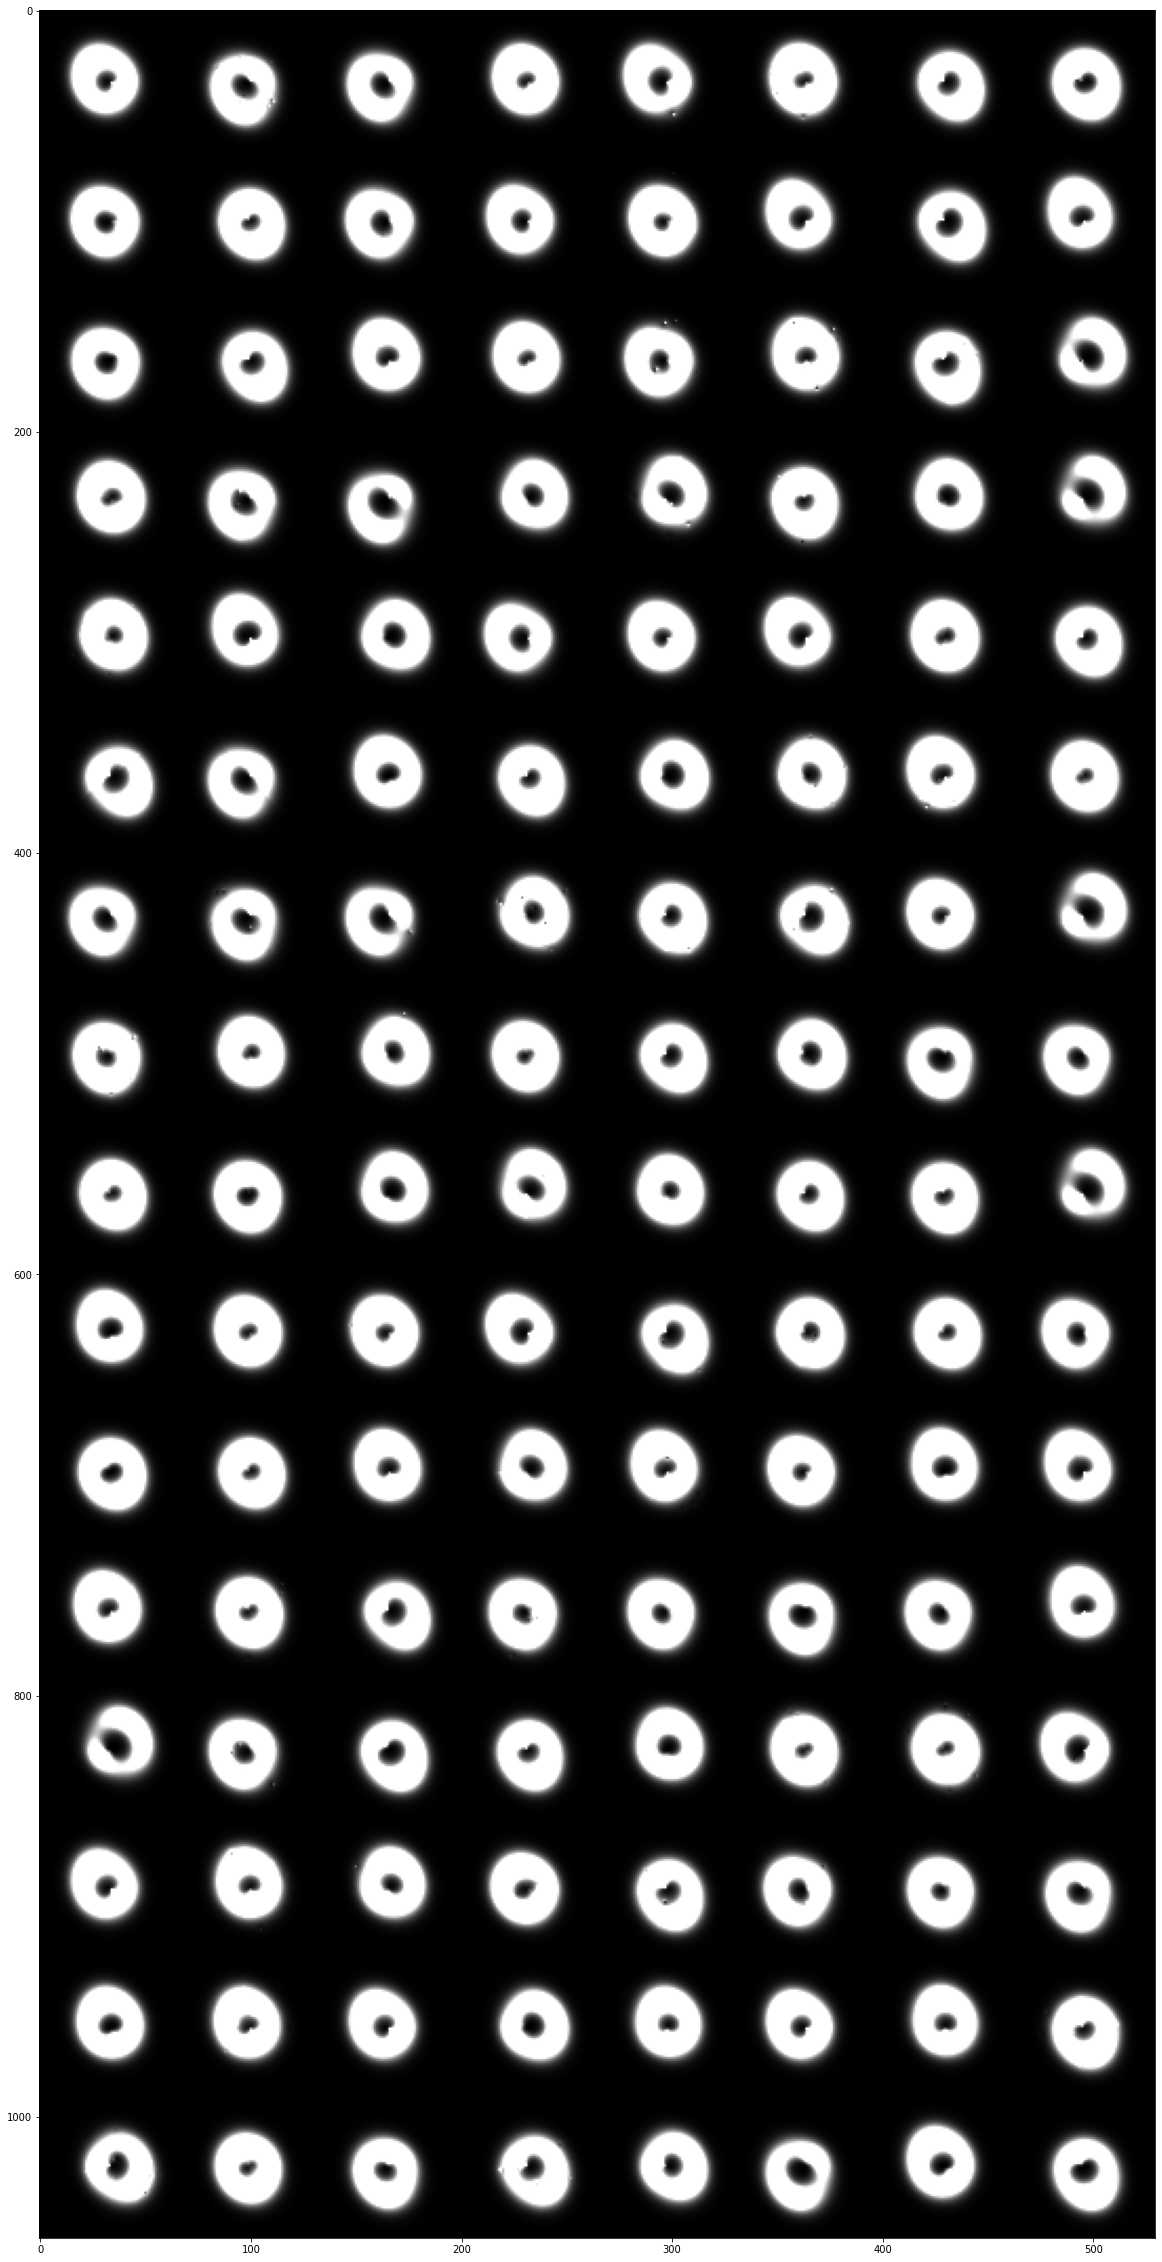

In [11]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=8)
plt.figure(figsize = (20,70))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [12]:
class pre_trained_model(nn.Module):
    
    def __init__(self, pretrained = True):
        super().__init__()
        self.model = timm.create_model('efficientnet_b1',pretrained = pretrained, in_chans = 1)
#         num_in_features = self.model.get_classifier().in_features
        
        for param in self.model.parameters():
            param.requires_grad = True            
        
        self.fc = nn.Sequential(
                                nn.Linear(1280 * 2 * 2, 1024),
                                nn.PReLU(),
                                nn.BatchNorm1d(1024),
                                nn.Dropout(p = 0.5),
                                
                                nn.Linear(1024, 512),
                                nn.BatchNorm1d(512),
                                nn.PReLU(),
                                nn.Dropout(p = 0.5),
        
                                nn.Linear(512, 128),
                                nn.PReLU(),
                                nn.BatchNorm1d(128),
                                nn.Dropout(p = 0.3),
                                
                                nn.Linear(128, 3)
                                )
        
    def forward(self, x):
        x = self.model.forward_features(x)
        x = x.view(-1, 1280 * 2 * 2)
        x = self.fc(x)
        return x

In [13]:
model = pre_trained_model()

x = torch.randn(64, 1, 50, 50)
print(model(x).shape)

del model
gc.collect()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth


torch.Size([64, 3])


8

In [14]:
def calculate_accuracy(y_pred, y_truth):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
    
    correct_preds = (y_pred_labels == y_truth).float()
    acc = correct_preds.sum() / len(correct_preds)
    acc = torch.round(acc*100)
    
    return acc  

In [15]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = []
    train_accuracy = []

    loop=tqdm(enumerate(dataloader),total = len(dataloader))

    for batch_idx, (img_batch,labels) in loop:

        X = img_batch.to(device)
        y_truth = labels.to(device)
        
        #forward prop
        y_pred = model(X)
        
        #loss and accuracy calculation
        loss = criterion(y_pred, y_truth)
        accuracy = calculate_accuracy(y_pred, y_truth)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #batch loss and accuracy
        # print(f'Partial train loss: {loss.data}')
        train_loss.append(loss.detach().cpu().numpy())
        train_accuracy.append(accuracy.detach().cpu().numpy())

    return model, np.mean(train_loss), np.mean(train_accuracy)

In [16]:
def val_epoch(model, dataloader,criterion):
    model.eval()
    val_loss = []
    val_accuracy = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)

            #forward prop
            y_pred = model(X)

            #loss and accuracy calculation
            loss = criterion(y_pred, y_truth)
            accuracy = calculate_accuracy(y_pred, y_truth)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            val_loss.append(loss.detach().cpu().numpy())
            val_accuracy.append(accuracy.detach().cpu().numpy())
            
    return np.mean(val_loss), np.mean(val_accuracy)

In [17]:
def fit_model(model,criterion,optimizer):
    loss_dict = {'train_loss':[],'val_loss':[]}
    acc_dict = {'train_accuracy':[],'val_accuracy':[]}
    
    scheduler = CosineAnnealingWarmRestarts(optimizer,T_0 = 5, T_mult = 1,eta_min = 1e-6, verbose=True)
    
#     scheduler = ReduceLROnPlateau(optimizer, 'min',patience=2,factor=0.3,verbose=True)


    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}:")
        model, train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = val_epoch(model, val_loader, criterion)
        scheduler.step()

        print(f'Train loss:{train_loss}, Val loss:{val_loss}')
        loss_dict['train_loss'].append(train_loss)
        loss_dict['val_loss'].append(val_loss)
        print(f'Train accuracy: {train_accuracy}, Val accuracy:{val_accuracy}')
        acc_dict['train_accuracy'].append(train_accuracy)
        acc_dict['val_accuracy'].append(val_accuracy)


    return model, loss_dict, acc_dict

In [18]:
model = pre_trained_model().to(device)

criterion = nn.CrossEntropyLoss()
EPOCHS = 10
LR = 3e-4

optimizer = optim.Adam(model.parameters(),lr=LR)

In [19]:
model, loss_dict, acc_dict = fit_model(model,criterion,optimizer)

Epoch 00000: adjusting learning rate of group 0 to 3.0000e-04.
Epoch 1/10:


  0%|          | 0/629 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00001: adjusting learning rate of group 0 to 2.7145e-04.
Train loss:0.1628635674715042, Val loss:0.0584133006632328
Train accuracy: 93.98091888427734, Val accuracy:98.12857055664062
Epoch 2/10:


  0%|          | 0/629 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00002: adjusting learning rate of group 0 to 1.9670e-04.
Train loss:0.03438332676887512, Val loss:0.02321390062570572
Train accuracy: 98.8108139038086, Val accuracy:99.27143096923828
Epoch 3/10:


  0%|          | 0/629 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00003: adjusting learning rate of group 0 to 1.0430e-04.
Train loss:0.01382614579051733, Val loss:0.024208595976233482
Train accuracy: 99.50556182861328, Val accuracy:99.04285430908203
Epoch 4/10:


  0%|          | 0/629 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00004: adjusting learning rate of group 0 to 2.9552e-05.
Train loss:0.005771246738731861, Val loss:0.011862706393003464
Train accuracy: 99.7869644165039, Val accuracy:99.65714263916016
Epoch 5/10:


  0%|          | 0/629 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00005: adjusting learning rate of group 0 to 3.0000e-04.
Train loss:0.001930956612341106, Val loss:0.006676755845546722
Train accuracy: 99.94117736816406, Val accuracy:99.75714111328125
Epoch 6/10:


  0%|          | 0/629 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00006: adjusting learning rate of group 0 to 2.7145e-04.
Train loss:0.023223621770739555, Val loss:0.0149280596524477
Train accuracy: 99.20668029785156, Val accuracy:99.38571166992188
Epoch 7/10:


  0%|          | 0/629 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00007: adjusting learning rate of group 0 to 1.9670e-04.
Train loss:0.008525577373802662, Val loss:0.16995523869991302
Train accuracy: 99.70270538330078, Val accuracy:93.54285430908203
Epoch 8/10:


  0%|          | 0/629 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00008: adjusting learning rate of group 0 to 1.0430e-04.
Train loss:0.003930156119167805, Val loss:0.008409736678004265
Train accuracy: 99.8521499633789, Val accuracy:99.71428680419922
Epoch 9/10:


  0%|          | 0/629 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00009: adjusting learning rate of group 0 to 2.9552e-05.
Train loss:0.0012876008404418826, Val loss:0.0042623295448720455
Train accuracy: 99.9475326538086, Val accuracy:99.82857513427734
Epoch 10/10:


  0%|          | 0/629 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00010: adjusting learning rate of group 0 to 3.0000e-04.
Train loss:0.00044620325206778944, Val loss:0.001847188570536673
Train accuracy: 99.98251342773438, Val accuracy:99.88571166992188


In [20]:
PATH = "effnetB2_centercrop.pth"
torch.save(model.state_dict(), PATH)

In [21]:
del model
gc.collect()

model = pre_trained_model().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

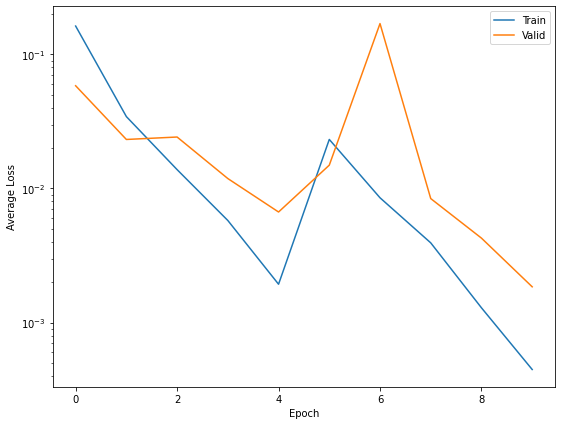

In [22]:
# # Plot losses
plt.figure(figsize=(9,7))
plt.semilogy(loss_dict['train_loss'], label='Train')
plt.semilogy(loss_dict['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

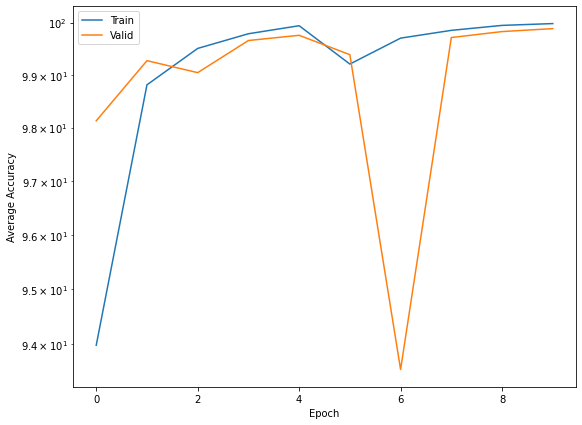

In [23]:
# Plot accuracy
plt.figure(figsize=(9,7))
plt.semilogy(acc_dict['train_accuracy'], label='Train')
plt.semilogy(acc_dict['val_accuracy'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [24]:
def test_epoch(model, dataloader,criterion):

    model.eval()
    test_loss = []
    test_accuracy = []
    
    y_pred_list = []
    y_pred_prob_list = []
    y_truth_list = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)
            y_truth_list.append(y_truth.detach().cpu().numpy())

            #forward prop
            y_pred = model(X)
            y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
            y_pred_prob_list.append(torch.softmax(y_pred, dim = 1).detach().cpu().numpy())
            _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
            y_pred_list.append(y_pred_labels.detach().cpu().numpy())

            #loss and accuracy calculation
            loss = criterion(y_pred, y_truth)
            accuracy = calculate_accuracy(y_pred, y_truth)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            test_loss.append(loss.detach().cpu().numpy())
            test_accuracy.append(accuracy.detach().cpu().numpy())
            
    return y_pred_prob_list, y_pred_list, y_truth_list, np.mean(test_loss), np.mean(test_accuracy)

In [25]:
y_pred_prob_list, y_pred_list, y_truth_list, test_loss, test_accuracy = test_epoch(model, test_loader, criterion)

print(test_loss, test_accuracy)

  0%|          | 0/118 [00:00<?, ?it/s]

0.0016986812 99.94068


In [26]:
def flatten_list(x):
    flattened_list = []
    for i in x:
        for j in i:
            flattened_list.append(j)
            
    return flattened_list

In [27]:
y_pred_list_flattened = flatten_list(y_pred_list)
y_truth_list_flattened = flatten_list(y_truth_list)
y_pred_prob_list_flattened = flatten_list(y_pred_prob_list)

In [28]:
idx2class = {v: k for k, v in dataset.class_map.items()}
class_names = [i for i in dataset.class_map.keys()]
idx2class

{0: 'axion', 1: 'no_sub', 2: 'cdm'}

In [29]:
print(classification_report(y_truth_list_flattened, y_pred_list_flattened,target_names = class_names))

              precision    recall  f1-score   support

       axion       1.00      1.00      1.00      5000
      no_sub       1.00      1.00      1.00      5000
         cdm       1.00      1.00      1.00      5000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



In [30]:
print(confusion_matrix(y_pred_list_flattened, y_truth_list_flattened))

[[4994    0    1]
 [   0 5000    0]
 [   6    0 4999]]


<AxesSubplot:>

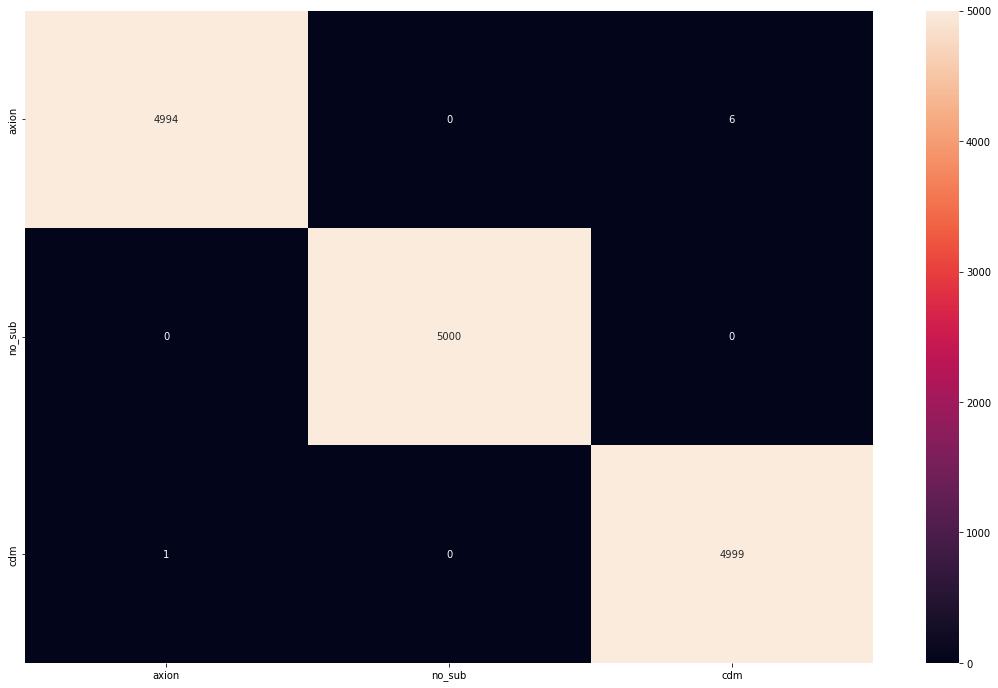

In [31]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_truth_list_flattened, y_pred_list_flattened)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(19,12))         
sns.heatmap(confusion_matrix_df, fmt = ".0f", annot=True, ax=ax)

In [32]:
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='macro', multi_class="ovr"))
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='macro', multi_class="ovo"))
print()
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='weighted', multi_class="ovr"))
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='weighted', multi_class="ovo"))

0.9999992266666666
0.9999992266666666

0.9999992266666666
0.9999992266666666


In [33]:
fpr = {}
tpr = {}
roc_auc = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(np.array(y_truth_list_flattened), np.array(y_pred_prob_list_flattened)[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

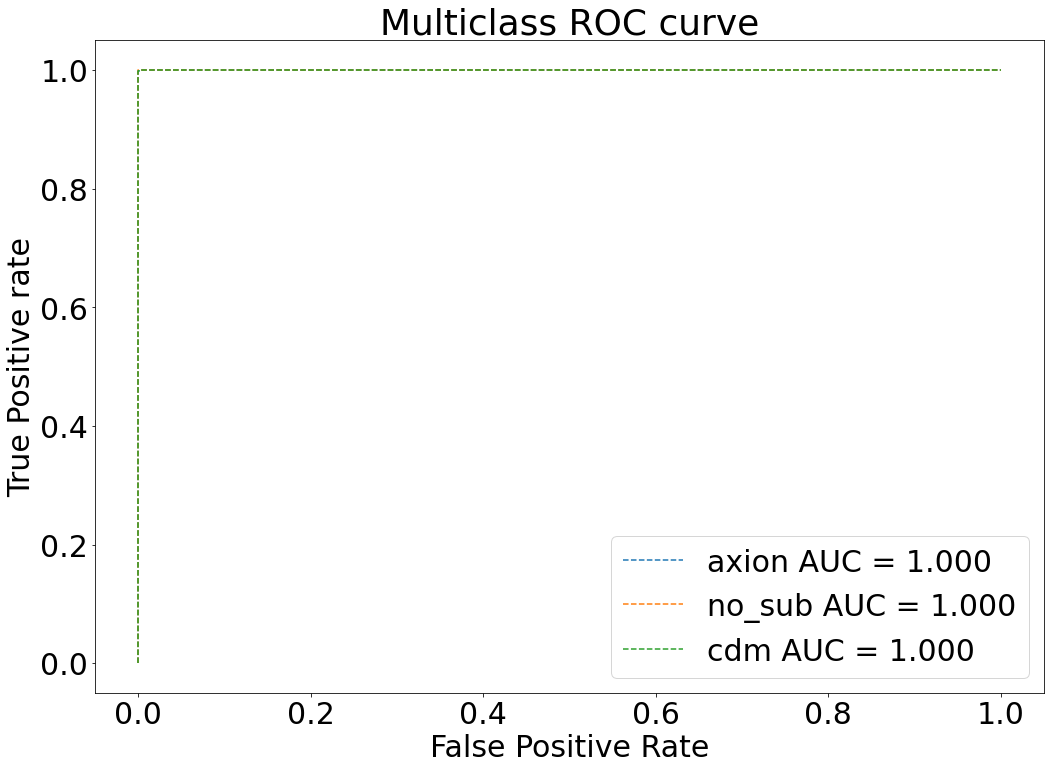

In [34]:
plt.figure(figsize=(17,12))
plt.rcParams['font.size'] = '30'
for i in range(0,n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'{idx2class[i]} AUC = {roc_auc[i]:.3f}')

    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    
plt.savefig('ROC_curves.png',dpi=352); 